### The notebook below was authored by Cathrine Bergh, Maryam Majdolhosseini and Alessandra Villa, as stated.

Small changes have been made by MAK so that it may run on a Jupyter notebook running on RunPod.

# Molecular dynamics simulation of a small protein using GROMACS 

    authors  : Cathrine Bergh, Maryam Majdolhosseini and Alessandra Villa.    
    goal     : learn step-by-step how to run a molecular dynamics simulation of a small protein using GROMACS 
    time     : 90 minutes
    software : GROMACS 2025 (2024, 2023), python modules: numpy, matplotlib, re, nglviewer, md_traj, pandas 
    optional software: visualization software [VMD](https://www.ks.uiuc.edu/Research/vmd), Xmgrace plotting tool
    tutorial source: tutorials.gromacs.org
    version  : release - doi:10.5281/zenodo.11198375

# Preparations to run this notebook

Before we can start running this notebook, there are a few Python libraries we will need to import. These are used for structure and trajectory visualizations (NGLview), reading and plotting data files (pandas), and handling MD trajectory data in Python (mdtraj). If you prefer to work in the terminal, commands for using Xmgrace for plotting and VMD for visualization will also be provided throughout the tutorial.

In [1]:
import os
os.environ['PATH'] += ":/usr/local/gromacs/bin"

In [2]:
import nglview as ng
import pandas as pd
import mdtraj as md

We will also need to change working directory into a prepared folder called "data":

In [8]:
# Change to the data directory
# Note that executing this command twice will result in an error you can ignore
#%cd data  # edited out by MAK
os.chdir("data")

/workspace/GMX_on_Runpod/data


In [12]:
# %ls
!ls


input  reference


In this folder all our generated data will be stored. All prepared input files are stored in the "input" folder and pre-computed reference simulation results in the "reference" folder. 

Now, we are all set to start running the tutorial!

# Obtaining the input for a simulation

The starting point for every simulation is a molecular structure file. In this tutorial, we will simulate Factor Xa - a protein playing a critical role in the formation of blood clots. The 3D structure is available from the RCSB website, https://www.rcsb.org/ with PDB code 1FJS. You can find the PDB file for the crystal structure in the "input" directory as a file called "ifjs.pdb".

Now, we visualize the structure:

In [13]:
view = ng.show_structure_file("input/1fjs.pdb")
view
# click and drag to rotate, zoom with your mouseweel 
# for more infor on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

Alternatively, you can use VMD to visualize the structure on your local machine. To run VMD from within this notebook, remove the comment character (#) in the following cell and VMD should pop up:
 **`close the VMD window after you are done looking at the protein to continue with this notebook`**

In [14]:
#!vmd input/1fjs.pdb

/bin/bash: line 1: vmd: command not found


## Cleaning the input structure

Once you've had a look at the molecule, you are going to want to strip out all the atoms that do not belong to the protein (e.i crystal waters, ligands, etc). To delete those atoms (labelled "HETATM" in the PDB file) and eventually their connectivity, either use a plain text editor like vi, emacs (Linux/Mac), or Notepad (Windows). Do not use word processing software! Alternatively, you can use grep to delete these lines very easily:

In [15]:
!grep -v HETATM input/1fjs.pdb > 1fjs_protein_tmp.pdb
!grep -v CONECT 1fjs_protein_tmp.pdb > 1fjs_protein.pdb

The cleaned structure now looks like this:

In [16]:
view = ng.show_structure_file("1fjs_protein.pdb")
view
# click and drag to rotate, zoom with your mouseweel 
# for more infor on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

In alternative, you can use VMD to visualize the structure on your local machine. To run VMD from within this notebook, remove the comment character (#) in the following cell and VMD should pop up:

In [17]:
#!vmd 1fjs_protein.pdb

Note *Such a procedure is not universally appropriate (e.g., the case of a tightly bound ligand or otherwise functional active-site water molecule).*

Always check your .pdb file for entries listed under the comment MISSING, as these entries indicate either atoms or whole residues that are not present in the crystal structure. Terminal regions may be absent, and may not present a problem for dynamics.

In [18]:
!grep MISSING input/1fjs.pdb

## Generating a topology

Now, that we have verified that our protein is whole and doesn't contain any uwanted atoms, we are ready to use it as input to GROMACS (see the <a href=http://manual.gromacs.org/current/index.html> GROMACS documentation </a>). 
The first GROMACS tool we will use is [`gmx pdb2gmx`](https://manual.gromacs.org/current/onlinehelp/gmx-pdb2gmx.html). The purpose of `gmx pdb2gmx` is to generate three files:

* The topology for the molecule (.itp)
* A position restraint file (.itp)
* A post-processed structure file (.gro)

The topology (topol.top by default) contains all the information necessary to define the molecule within a simulation. This information includes nonbonded parameters (atom types and charges) as well as bonded parameters (bonds, angles, dihedrals and atom connectivity). We will take a more detailed look at the topology once it has been generated.

<div class="alert alert-block alert-info">
<b>NOTE:</b> Incomplete internal sequences or any amino acid residues that have missing atoms will cause `gmx pdb2gmx` to fail. These missing atoms/residues must be modeled in using other software packages. Also note that `gmx pdb2gmx` is not magic. It cannot generate topologies for arbitrary molecules, just the residues defined by the force field (in the *.rtp files - generally proteins, nucleic acids, and a very finite amount of cofactors, like NAD(H) and ATP).
</div>

Execute `gmx pdb2gmx` by the following command:

In [34]:
!gmx pdb2gmx -f 1fjs_protein.pdb -renum -o 1fjs_processed.gro -water tip3p -ff "charmm27"
# MAK added -renum

                     :-) GROMACS - gmx pdb2gmx, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx pdb2gmx -f 1fjs_protein.pdb -renum -o 1fjs_processed.gro -water tip3p -ff charmm27

Using the Charmm27 force field in directory charmm27.ff

going to rename charmm27.ff/aminoacids.r2b
Opening force field file /usr/local/gromacs/share/gromacs/top/charmm27.ff/aminoacids.r2b

going to rename charmm27.ff/rna.r2b
Opening force field file /usr/local/gromacs/share/gromacs/top/charmm27.ff/rna.r2b
Reading 1fjs_protein.pdb...
Read 'COAGULATION FACTOR XA; COAGULATION FACTOR XA', 2236 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 2 chains and 0 blocks of water and 286 residues with 2236 atoms

  chain  #res #atoms

  1 'A'   234   1852  

  2 'L'    52    384  

there were 14 atoms with zero occupancy and 20 atoms with          occupancy unequa

Here, we made an important decision for the course of the simulation in choosing the CHARMM27 all-atom force field. The force field will contain the information that will be written to the topology. This is a very important choice! You should always read thoroughly about each force field and decide which is most applicable to your situation. A prompt with more force field options (shown below) will open when running `gmx pdb2gmx` without the `-ff` flag.

    Select the Force Field:
    From '/usr/local/gromacs/share/gromacs/top':
     1: AMBER03 protein, nucleic AMBER94 (Duan et al., J. Comp. Chem. 24, 1999-2012, 2003)
     2: AMBER94 force field (Cornell et al., JACS 117, 5179-5197, 1995)
     3: AMBER96 protein, nucleic AMBER94 (Kollman et al., Acc. Chem. Res. 29, 461-469, 1996)
     4: AMBER99 protein, nucleic AMBER94 (Wang et al., J. Comp. Chem. 21, 1049-1074, 2000)
     5: AMBER99SB protein, nucleic AMBER94 (Hornak et al., Proteins 65, 712-725, 2006)
     6: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)
     7: AMBERGS force field (Garcia & Sanbonmatsu, PNAS 99, 2782-2787, 2002)
     8: CHARMM27 all-atom force field (CHARM22 plus CMAP for proteins)
     9: GROMOS96 43a1 force field
    10: GROMOS96 43a2 force field (improved alkane dihedrals)
    11: GROMOS96 45a3 force field (Schuler JCC 2001 22 1205)
    12: GROMOS96 53a5 force field (JCC 2004 vol 25 pag 1656)
    13: GROMOS96 53a6 force field (JCC 2004 vol 25 pag 1656)
    14: GROMOS96 54a7 force field (Eur. Biophys. J. (2011), 40,, 843-856, DOI: 10.1007/s00249-011-0700-9)
    15: OPLS-AA/L all-atom force field (2001 aminoacid dihedrals)


There are many other options that can be passed to `gmx pdb2gmx` (see the [manual](http://manual.gromacs.org/documentation/current/onlinehelp/gmx-pdb2gmx.html)). Some commonly used ones are listed here:

| Option | Effect |
|--------|--------
|-water  | Water model to use: none, spc, spce, tip3p, tip4p, tip5p, tips3p.|
|-ignh   | Ignore H atoms in the PDB file; especially useful for NMR structures. Otherwise, if H atoms are present, they must be in the named exactly how the force fields in GROMACS expect them to be. Different conventions exist, so dealing with H atoms can occasionally be a headache! If you need to preserve the initial H coordinates, but renaming is required, then the Linux sed command is your friend.|
|-ter    | Interactively assign charge states for N- and C-termini.|
|-inter  | Interactively assign charge states for Glu, Asp, Lys, Arg, and His; choose which Cys are involved in disulfide bonds.|

## A peek at the generated files

When running `gmx pdb2gmx` four new files were generated: 1fjs_processed.gro, topol.top, topol_Protein_chain_X.itp and posre_Protein_chain_X.itp. You now have the following files in your data folder:

In [35]:
!ls

'#1fjs_processed.gro.1#'	  1fjs_protein_tmp.pdb
'#posre_Protein_chain_A.itp.1#'   input
'#posre_Protein_chain_L.itp.1#'   posre_Protein_chain_A.itp
'#topol.top.1#'			  posre_Protein_chain_L.itp
'#topol_Protein_chain_A.itp.1#'   reference
'#topol_Protein_chain_L.itp.1#'   topol.top
 1fjs_processed.gro		  topol_Protein_chain_A.itp
 1fjs_protein.pdb		  topol_Protein_chain_L.itp


1fjs_processed.gro is a GROMACS-formatted structure file that contains all the atoms defined within the force field (i.e., H atoms have been added to the amino acids in the protein). The topol.top file is the system topology (more on this in a minute). The posre files contain information used to restrain the positions of heavy atoms (more on this later).

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> Many users assume that a .gro file is mandatory. This is not true. GROMACS can handle many different file formats, with .gro simply being the default for commands that write coordinate files. It is a very compact format, but it has limited precision. If you prefer to use, for instance, PDB format, all you need to do is to specify an appropriate file name with .pdb extension as your output. The purpose of `gmx pdb2gmx` is to produce a force field-compliant topology; the output structure is largely a side effect of this purpose and is intended for user convenience. The format can be just about anything you like, see https://manual.gromacs.org/documentation/current/reference-manual/file-formats.html for different format. 
</div>

# Understanding molecule "topologies"

First, let's have a look at the output topology file (topol.top). Using a plain text editor, we inspect its contents:

In [36]:
!cat topol.top

;
;	File 'topol.top' was generated
;	By user: unknown (0)
;	On host: 8ae102e4dc77
;	At date: Thu Jun  5 18:54:38 2025
;
;	This is a standalone topology file
;
;	Created by:
;	                    :-) GROMACS - gmx pdb2gmx, 2025.0 (-:
;	
;	Executable:   /usr/local/gromacs/bin/gmx
;	Data prefix:  /usr/local/gromacs
;	Working dir:  /workspace/GMX_on_Runpod/data
;	Command line:
;	  gmx pdb2gmx -f 1fjs_protein.pdb -renum -o 1fjs_processed.gro -water tip3p -ff charmm27
;	Force field was read from the standard GROMACS share directory.
;

; Include forcefield parameters
#include "charmm27.ff/forcefield.itp"

; Include chain topologies
#include "topol_Protein_chain_A.itp"
#include "topol_Protein_chain_L.itp"

; Include water topology
#include "charmm27.ff/tip3p.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif

; Include topology for ions
#include "charmm27.ff/i

The file begins with many comments (lines beginning with ; ), which specify some meta data regarding the file, e.g. by who, when and how it was created. The first un-commented line calls the parameters of the chosen force field. It is at the beginning of the file, indicating that all subsequent parameters are derived from this force field. 

After that, we include the topologies of our two protein molecules that were generated by `pdb2gmx`. First, we take a look at the `[ moleculetype ]` section of the protein itp file:

In [37]:
!grep "moleculetype" -A 3 topol_Protein_chain_A.itp

[ moleculetype ]
; Name            nrexcl
Protein_chain_A     3



and

In [38]:
!grep "moleculetype" -A 3 topol_Protein_chain_L.itp

[ moleculetype ]
; Name            nrexcl
Protein_chain_L     3



The name "Protein_chain_A" defines the molecule name, based on the fact that the protein was labeled as chain A in the PDB file. There are 3 exclusions for bonded neighbors. More information on exclusions can be found in the <a href=http://manual.gromacs.org/current/reference-manual/topologies.html>GROMACS manual</a>.

## Atoms in a topology

The next section defines the `[ atoms ]` in the protein. The information is presented as columns:

In [39]:
! grep "atoms" -A 4 topol_Protein_chain_A.itp

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
; residue   1 ILE rtp ILE  q +1.0
     1        NH3      1    ILE      N      1       -0.3     14.007
     2         HC      1    ILE     H1      2       0.33      1.008


The interpretation of this information is as follows:

|Field  |  description |
|--|--
|nr|Atom number
|type| Atom type
|resnr|Amino acid residue number
|residue| The amino acid residue name- Note that this may be different from .rtp entry. 
|atom| Atom name
|cgnr| Charge group number - Not used anymore 
|charge| Self-explanatory - The "qtot" descriptor is a running total of the charge on the molecule
|mass| Also self-explanatory
|typeB, chargeB, massB| Used for free energy perturbation (not discussed here) 

## Bonds and other interactions

Subsequent sections include `[ bonds ]`, `[ pairs ]`, `[ angles ]`, and `[ dihedrals ]`. Some of these sections are self-explanatory (bonds, angles, and dihedrals). More information about these interactions can be found [here](http://manual.gromacs.org/current/reference-manual/functions.html) and special 1-4 interactions are included under [pairs](http://manual.gromacs.org/current/reference-manual/functions/interaction-methods.html#exclusions-and-1-4-interactions). For formats associated with function types [see topology file table](http://manual.gromacs.org/documentation/2020-beta1/reference-manual/topologies/topology-file-formats.html) in the GROMACS manual.

Next, we take a look at the different types of interactions listed in the topology file. For now, we only look at chain A, although the file for the other chain will look very similar.

Bonded interactions:

In [40]:
!grep "bonds" -A 2 topol_Protein_chain_A.itp

[ bonds ]
;  ai    aj funct            c0            c1            c2            c3
    1     2     1 


Pair interactions

In [41]:
!grep "pairs" -A 2  topol_Protein_chain_A.itp

[ pairs ]
;  ai    aj funct            c0            c1            c2            c3
    1     8     1 


Angle interactions

In [42]:
!grep "angles" -A 2 topol_Protein_chain_A.itp

[ angles ]
;  ai    aj    ak funct            c0            c1            c2            c3
    2     1     3     5 


Dihedral interactions

In [43]:
!grep "dihedrals" -A 2 topol_Protein_chain_A.itp

[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3            c4            c5
    2     1     5     6     9 
--
[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3
   20     5    22    21     2 


In the commands above we only listed one interaction per type. If you look at the full data file, there will of course be many more interactions!

## Water and position restraints

The remainder of the file involves including a few other useful/necessary topologies, starting with position restraints. The "posre.itp" file was generated by `gmx pdb2gmx`; it defines a force constant used to keep atoms in place during equilibration (more on this later).

In [44]:
!grep "posre" topol*.itp

topol_Protein_chain_A.itp:#include "posre_Protein_chain_A.itp"
topol_Protein_chain_L.itp:#include "posre_Protein_chain_L.itp"


In [45]:
!cat posre_Protein_chain_A.itp

; In this topology include file, you will find position restraint
; entries for all the heavy atoms in your original pdb file.
; This means that all the protons which were added by pdb2gmx are
; not restrained.

[ position_restraints ]
; atom  type      fx      fy      fz
     1     1  1000  1000  1000
     5     1  1000  1000  1000
     7     1  1000  1000  1000
     9     1  1000  1000  1000
    13     1  1000  1000  1000
    16     1  1000  1000  1000
    20     1  1000  1000  1000
    21     1  1000  1000  1000
    22     1  1000  1000  1000
    24     1  1000  1000  1000
    26     1  1000  1000  1000
    28     1  1000  1000  1000
    32     1  1000  1000  1000
    36     1  1000  1000  1000
    37     1  1000  1000  1000
    38     1  1000  1000  1000
    40     1  1000  1000  1000
    43     1  1000  1000  1000
    44     1  1000  1000  1000
    45     1  1000  1000  1000
    47     1  1000  1000  1000
    50     1  1000  1000  1000
    51     1  1000  1000  1000
    52     1  

Here ends the "Protein_chain_A" moleculetype definition. Then the "Protein_chain_L" moleculetype definition starts. 

The remainder of the topology file is dedicated to defining other molecules and providing system-level descriptions. The next moleculetype (by default) is the solvent, in this case TIP3P water. Other typical choices for water include SPC, SPC/E, and TIP4P. We chose the water model TIP3P by passing `-water tip3p` to `gmx pdb2gmx` and we can see it has been included in the topology file together with a definition of its positions restraints:

In [46]:
!grep "Include water topology" -A 8 topol.top

; Include water topology
#include "charmm27.ff/tip3p.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif


For an excellent summary of the many different water models, click [here](http://www1.lsbu.ac.uk/water/water_models.html), but be aware that not all of these models available within GROMACS.

## Ions and other parameters

In the next section of the topology file we find parameters related to ions:

In [47]:
!grep "ions" topol.top

; Include topology for ions
#include "charmm27.ff/ions.itp"


## System level definitions

Finally come system-level definitions. The `[ system ]` directive gives the name of the system that will be written to output files during the simulation. The `[ molecules ]` directive lists all of the molecules in the system.

In [48]:
!tail -8 topol.top

[ system ]
; Name
COAGULATION FACTOR XA; COAGULATION FACTOR XA

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1


Some things to note regarding the `[ molecules ]` directive:

- The order of the listed molecules must exactly match the order of the molecules in the coordinate file (in this case, .gro).
- The names listed must match the `[ moleculetype ]` name for each species, not residue names or anything else.

If you fail to satisfy these requirements at any time, you will get fatal errors from `grompp` (which will be discussed later) about mismatched names or molecules not being found.

Now that we have examined the contents of a topology file, we can continue building our system.

# Solvating the simulation system

Now that you are familiar with the contents of the GROMACS topology file, it is time to continue building our system. In this example, we are going to be simulating a simple aqueous system. It is possible to simulate proteins and other molecules in different solvents, provided that good parameters are available for all species involved.

To solvate our protein, two steps will be required:

- Define the box dimensions using the [`gmx editconf`](https://manual.gromacs.org/current/onlinehelp/gmx-editconf.html) tool.
- Fill the box with water using the [`gmx solvate`](https://manual.gromacs.org/current/onlinehelp/gmx-solvate.html) tool. 

You are now presented with a choice as to how to treat the unit cell. For the purpose of this tutorial, we will use the rhombic dodecahedron, as its volume is ~71% of the cubic box of the same periodic distance, thus saving on the number of water molecules that need to be added to solvate the protein.

## Defining the simulation box

Let's define the box using `gmx editconf`:

In [49]:
!gmx editconf -f 1fjs_processed.gro -o 1fjs_newbox.gro -c -d 1.0 -bt dodecahedron

                     :-) GROMACS - gmx editconf, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx editconf -f 1fjs_processed.gro -o 1fjs_newbox.gro -c -d 1.0 -bt dodecahedron

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 4417 atoms
Volume: 321.98 nm^3, corresponds to roughly 144800 electrons
No velocities found
    system size :  6.066  5.213  4.092 (nm)
    diameter    :  6.268               (nm)
    center      :  2.234  1.342  2.544 (nm)
    box vectors :  5.577  7.196  8.023 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 321.98               (nm^3)
    shift       :  3.967  4.858  0.379 (nm)
new center      :  6.201  6.201  2.923 (nm)
new box vectors :  8.268  8.268  8.268 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 399.60               (nm^3)

GROMACS reminds you: "Get Down In

The above command centers the protein in the box (`-c`), and places it at least 1.0 nm from the box edge (`-d 1.0`). The box type is defined as a rhombic dodecahedron (`-bt dodecahedron`). Have a look at this [section](http://manual.gromacs.org/current/reference-manual/algorithms/periodic-boundary-conditions.html#pbc) in the manual for more on periodic boundary conditions and dodecahedrons.

The distance to the edge of the box is an important parameter. A protein should never interact with its periodic image (minimum image convention), otherwise the forces calculated will be spurious. The minimum image convention implies that the distance between two periodic images of the protein should be larger than the cut-off radius used to truncate non-bonded interactions. Here we will use a cut-off radius of 1.2 nm (see below). Specifying a solute-box distance of 1.0 nm will mean that there are at least 2.0 nm between any two periodic images of a protein. We expect that at that distance all protein-protein interactions are negligible.

## Filling the box with water

In [50]:
!gmx solvate -cp 1fjs_newbox.gro -cs spc216.gro -o 1fjs_solv.gro -p topol.top

                     :-) GROMACS - gmx solvate, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx solvate -cp 1fjs_newbox.gro -cs spc216.gro -o 1fjs_solv.gro -p topol.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND

The configuration of the protein (`-cp`) is contained in the output of the previous `gmx editconf` step, and the configuration of the solvent (`-cs`) is part of the standard GROMACS installation. We are using "spc216.gro", which is a generic equilibrated 3-point solvent model box. You can use spc216.gro as the solvent configuration for SPC, SPC/E, or TIP3P water, since they are all three-point water models. The output is called 1fjs_solv.gro, and we tell solvate the name of the topology file ("topol.top") so it can be modified. Note the changes to the `[ molecules ]` directive of topol.top:

In [51]:
!tail topol.top


[ system ]
; Name
COAGULATION FACTOR XA; COAGULATION FACTOR XA in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1
SOL             11777



`gmx solvate` kept track of how many water molecules it has added, which it then writes to your topology. Note that if you use any other (non-water) solvent,`gmx solvate` will not make these changes to your topology! Its compatibility with updating water molecules is hard-coded. Also note that `gmx solvate` *adds* this data to the topology file - it doesn't overwrite the topology file like it does for the coordinate file. If you run `gmx solvate` multiple times, you might therefore get a mismatch between the number of water molecules in your topology and coordinate file!

Finally, let's see what our system looks like:

In [120]:
view = ng.show_structure_file("1fjs_solv.gro")
view.add_representation(repr_type='ball+stick', selection='SOL')
#view.camera='orthographic'
view

NGLWidget()

We can see that water molecules have been added inside the box we created previously. Since many visualization programs visualize whole molecules by default, it looks like the protein sticks out of the box as it enters its periodic image.

# Adding Ions

We now have a solvated system that contains a charged protein. The output of `pdb2gmx` told us that the protein has a net charge of -2e (based on its amino acid composition). If you missed this information in the `pdb2gmx` output, look at the last line of each [ atoms ] directive in topology file; it should read  "qtot 1." for chain A and  "qtot -3." for chain L. Since life does not exist at a net charge, we must add ions to our system. Further, we aim to approximate physiological conditions and therefore use a NaCl concentration of 0.15 M.

## Preparing the input for "gmx genion"

The tool for adding ions within GROMACS is called [`gmx genion`](https://manual.gromacs.org/current/onlinehelp/gmx-genion.html). What `gmx genion` does is read through the topology and replace water molecules with the ions that the user specifies. The input is called a run input file, which has an extension of .tpr; this file is produced by the GROMACS grompp module (GROMACS pre-processor), which will also be used later when we run our first simulation. `gmx grompp` processes the coordinate file and topology (which describes the molecules) to generate an atomic-level input (.tpr). The .tpr file contains all the parameters for all of the atoms in the system.

To produce a .tpr file with [`gmx grompp`](https://manual.gromacs.org/current/onlinehelp/gmx-grompp.html), we will need an additional input file, with the extension .mdp (molecular dynamics parameter file); `gmx grompp` will assemble the parameters specified in the .mdp file with the coordinates and topology information to generate a .tpr file.

An .mdp file is normally used to run energy minimization or an MD simulation, but in this case it is simply used to generate an atomic description of the system. We can proceed with a completely empty .mdp file in this case since its only role is to create the .tpr file.

In [53]:
!touch ions.mdp

Assemble your .tpr file with the following:

In [54]:
!gmx grompp -f ions.mdp -c 1fjs_solv.gro -p topol.top -o ions.tpr

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx grompp -f ions.mdp -c 1fjs_solv.gro -p topol.top -o ions.tpr


NOTE 1 [file ions.mdp]:
  For a correct single-point energy evaluation with nsteps = 0, use
  continuation = yes to avoid constraining the input coordinates.

Setting the LD random seed to -161259650

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 2 [file topol.top, line 48]:
  System has non-zero total charge: -2.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html
  f

Be aware that there are some notes in the output. In all cases other than generating an output tpr file for `gmx genion`, these are very important and should not be ignored. Here, however, we only need the atomic-level description of our system in the binary file ions.tpr. We will pass this file to genion:

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> Many GROMACS tools promt for input at the command line. As this does not play well with the Jupyter notebook setup, we feed the input to the command line with a print command and a newline \n substituting enter.
</div>

In [55]:
!printf "SOL\n" | gmx genion -s ions.tpr -o 1fjs_solv_ions.gro -conc 0.15 -p \
topol.top -pname NA -nname CL -neutral

                      :-) GROMACS - gmx genion, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx genion -s ions.tpr -o 1fjs_solv_ions.gro -conc 0.15 -p topol.top -pname NA -nname CL -neutral

Reading file ions.tpr, VERSION 2025.0 (single precision)
Reading file ions.tpr, VERSION 2025.0 (single precision)
Will try to add 38 NA ions and 36 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 39748 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    10 (

We chose group "SOL" for embedding ions. You do not want to replace parts of your protein with ions.

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> Make sure to run `gmx genion` only once. `gmx genion` edits the topology "in-place" and does not know if there are already Cl or Na ions in the system. If you run it over again, ions will be added until there is no water left to replace with ions.
</div>

In the `gmx genion` command, we provide the structure/state file (-s) as input, generate a .gro file as output (-o), process the topology (-p) to reflect the removal of water molecules and addition of ions, define positive and negative ion names (-pname and -nname, respectively), and tell `gmx genion` to add ions necessary to neutralize the net charge on the protein by adding the correct number of negative ions (-neutral, which in this case will add 2 Na+ ions to offset the -2 charge on the protein). We further use genion to add a specified concentration of ions in addition to simply neutralizing the system by specifying the -neutral and -conc options in conjunction. Refer to the genion manual page for information on how to use these options.

The names of the ions specified with -pname and -nname GROMACS are standardized and not dependent on the force-field. The specified ion names are always the elemental symbol in all capital letters, which is the [ moleculetype ] name that is then written to the topology. Residue or atom names may or may not append the sign of the charge (+/-), depending on the force field. Do not use atom or residue names in the genion command, or you will encounter errors in subsequent steps.

Your [ molecules ] directive should now be similar to

    [ molecules ]
    ; Compound      #mols
    Protein_chain_A    1
    Protein_chain_L    1
    SOL           11703
    NA              38
    CL              36

Let's check the last lines of the topology file

In [56]:
!tail -6 topol.top

; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1
SOL         11703
NA               38
CL               36


If you see multiple lines of NA and CL, you most likely ran genion multiple times. Start over with `pdb2gmx`.

Finally, let's take a look at what our system looks like now:

In [57]:
view = ng.show_structure_file("1fjs_solv_ions.gro")
view.add_representation(repr_type='spacefill', selection='NA')
view.add_representation(repr_type='spacefill', selection='CL')
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'
view

NGLWidget()

We can see that some water molecules have been replaced with sodium (purple) and chloride (green) ions.

# Energy minimisation

The solvated, electroneutral system is now assembled. Before we can begin dynamics, we must ensure that the system has no steric clashes or inappropriate geometry. The structure is relaxed through a process called energy minimization (EM).

To perform energy minimization, we are once again going to use `gmx grompp` to assemble the structure, topology, and simulation parameters into a binary input file (.tpr), then we will use GROMACS MD engine, mdrun, to run the energy minimization.

Assemble the binary input using `gmx grompp` using the .mdp parameter file, as input. The simulation parameter file (.mdp) determines how the simulation shall be run. Find more information on all the options in the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html) or in the following [webinar](https://bioexcel.eu/webinar-a-walk-through-simulation-parameter-options-mdp-files-for-gromacs-2019-12-05/). There are a lot of parameters that can be set, here we ony set the elemental parametes and leave everything else as default. Let's have a look at the input file:

In [58]:
!cat input/emin-charmm.mdp

title       = CHARMM steepest descent enrgy minimisation

; Parameters describing what to do, when to stop and what to save
integrator  = steep  ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0 ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01   ; Minimization step size
nstenergy   = 500    ; save energies every 1.0 ps, so we can observe if we are successful
nsteps      = -1     ; run as long as we need
; Settings that make sure we run with parameters in harmony with the selected force-field
constraints             = h-bonds   ; bonds involving H are constrained
rcoulomb                = 1.2       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.2       ; short-range van der Waals cutoff (in nm)
vdw-modifier            = Force-switch ;  specific CHARMM
rvdw_switch             = 1.0       ;
DispCorr                = no        ; account for cut-off vdW scheme -
;in case of CHARMM DispCorr = EnerPres only for mon

In [59]:
!gmx grompp -f input/emin-charmm.mdp -c 1fjs_solv_ions.gro -p topol.top -o em.tpr

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx grompp -f input/emin-charmm.mdp -c 1fjs_solv_ions.gro -p topol.top -o em.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -168574980

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...
Analysing residue names:


Make sure you have been updating your topol.top file when running genbox and genion, or else you will get lots of nasty error messages ("number of coordinates in coordinate file does not match topology," etc).

Once run, we will find the energy-minimized structure in a file called `em.gro`. Additionally, we will find more information on the run in an ASCII-text log file of the EM process,  `em.log`, a file for storage of energy, `em.edr` and a binary full-precision trajectory `em.trr`. 


We are now ready to run mdrun to carry out the energy minimisation:

In [60]:
!gmx mdrun -v -deffnm em -ntmpi 1 -ntomp 1

                      :-) GROMACS - gmx mdrun, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx mdrun -v -deffnm em -ntmpi 1 -ntomp 1

Reading file em.tpr, VERSION 2025.0 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 1 OpenMP thread 


NOTE: OS CPU limit is lower than logical cpu count, thread pinning disabled.

Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =           -1
Step=    0, Dmax= 1.0e-02 nm, Epot= -1.61449e+05 Fmax= 4.68463e+05, atom= 2834
Step=    1, Dmax= 1.0e-02 nm, Epot= -1.94515e+05 Fmax= 1.25623e+05, atom= 17762
Step=    2, Dmax= 1.2e-02 nm, Epot= -2.61150e+05 Fmax= 4.30238e+04, atom= 17762
Step=    3, Dmax= 1.4e-02 n

The -v flag is for the impatient: it makes `gmx mdrun` verbose, such that it prints its progress to the screen at every step. Never use this flag if run in background, on a HPC center or on a local cluster - it prints a lot of unnecessary data to the standard output file. 
The -deffnm flag will define the file names of the input and output. So, if you did not name your grompp output "em.tpr," you will have to explicitly specify its name with the `gmx mdrun` -s flag. The flag -ntpmi and -ntomp tell how many MPI theads and OpenMP threads to use. 

*Note: if you do not want to wait, but look at some of the results directly, copy the data from the /reference directory into the current directory. To do this from within this notebook, remove the comment characters (#) in the following cell:*

In [61]:
## ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/em_charmm.edr em.edr
#!cp reference/em_charmm.gro em.gro

## Determining if the run was successful

There are two very important factors to evaluate whether the EM was successful or not. 

The first is the potential energy (printed at the end of the EM process, even without -v). Epot should be negative and (for a simple protein in water) on the order of 100000 kJ/mol, depending on the system size and number of water molecules.

The second important property is the maximum force, Fmax, the target for which was set in minim.mdp - "emtol = 1000.0" - indicating a target Fmax no greater than 1000 kJ/(mol nm). It is possible to arrive at a reasonable Epot with Fmax > emtol. If this happens, your system may not be stable enough for simulation. Then, you will need to identify the underlying cause and perhaps change your minimization parameters (integrator, emstep, etc).



## Analysing the run results

Let's do a bit of analysis. The em.edr file contains all of the energy terms that GROMACS collects during EM. You can analyze any .edr file using the GROMACS energy module.

To analyse or visualize simulation data in Python or Jupyter notebooks, we can output a simplified xvg format from gmx-analysis tools with the option `-xvg none`

In [62]:
!printf "Potential\n0\n" | gmx energy -f em.edr -o potential.xvg -xvg none

                      :-) GROMACS - gmx energy, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx energy -f em.edr -o potential.xvg -xvg none

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ          20  Vir-ZX        
 21  Vir-ZY          22  Vir-ZZ          23  Pres-XX         24  Pres-XY

You will be shown the average of Epot, and a file called "potential.xvg" will be written. To plot this data file, you can use the script below. The resulting plot should show a steady convergence of Epot.

<Axes: xlabel='step'>

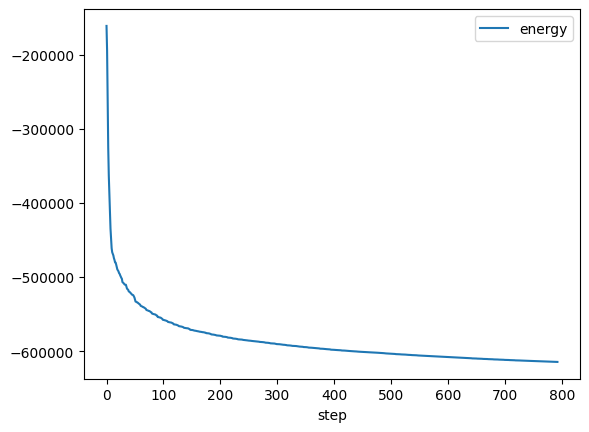

In [63]:
df = pd.read_csv('potential.xvg', sep='\\s+', header=None, names=['step','energy'])
df.plot('step')

Alternatively, you can plot the data using the Xmgrace plotting tool, which might be more conventient if you work directly in the terminal. To use Xmgrace from this notebook, remove the comment character (#) in the following cells:

First, generate the xvg file:

In [64]:
#!printf "Potential\n0\n" | gmx energy -f em.edr -o potential.xvg

Plot with Xmgrace: 

In [65]:
#!xmgrace potential.xvg

Now that our system is at an energy minimum, we can begin real dynamics.

# Position restraints 

EM reduced the largest fores by slightly moving and rotating atoms, but the system as a whole is by no means at its equilibrium state yet. Before we begin real dynamics, we must therefore equilibrate the solvent and ions around the protein. If we were to attempt unrestrained dynamics at this point, the system could collapse. When we used `gmx solvate`, water molecules were placed in semi-ordered fashion (look at the visualization after we filled the box with water) and ions were placed by replacing some of these waters. This semi-ordered configuration is not something that would be represented by the force field, so we need to let the molecules move a bit to enter into a such a configuration.

Remember that posre.itp file which `pdb2gmx` generated a long time ago? We're going to use it now. The purpose of posre.itp is to apply a position-restraining force on the heavy atoms in the protein (anything that is not a hydrogen). Movement is permitted, but only after overcoming a substantial energy penalty. The advantage of position restraints is that they allow us to relax our solvent and ions around our protein, without letting the protein move. The origin of the position restraints (the coordinates at which the restraint potential is zero) is provided via a coordinate file passed via the -r option of `grompp`.

To use position restraints we need to add \"define = -DPOSRES\" to the simulation parameter file, .mdp, (more details on the simulation parameters below). Have a look at the .mdp file for this run:

In [66]:
!head -5 input/nvt-charmm.mdp 

title                   = CHARMM NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator


When using position restraints, a file with restraint coordinates must be supplied to `gmx grompp` through the -r option (see below). It can be the same file as supplied for -c. 

# Equilibration run - temperature

Equilibration is often conducted in two phases. The first phase is conducted under an NVT ensemble (constant Number of particles, Volume, and Temperature). This ensemble is also referred to as "isothermal-isochoric" or "canonical." The timeframe for such a procedure is dependent upon the contents of the system. Typically, 100-200 ps should suffice, and we will conduct a 100-ps NVT equilibration for this exercise. Depending on your machine, this may take a while (just under an hour if run in parallel on 16 cores or so).

The point of the NVT equilibration is get our system to the temperature we wish to simulate by applying a thermostat, which usually works by modifying the atom velocities according to the kinetic energy ditributions predicted at the given temperature. Another point, which we discussed in the previous section, is to let the solvent molecules move and orient themselves around the protein surface, potentially entering pockets or crevices. Depending on the protein structure, this aspect can greatly influence how much equilibration time is needed.

To run the equilibration, we will call `grompp` and `mdrun` as in the EM step, but this time using the energy minimised structure as input and a different .mdp parameter file. Let's look at the mdp file for this run:

In [67]:
!cat input/nvt-charmm.mdp

title                   = CHARMM NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

; Keep system temperature fluctuating physically correct
tcoupl                  = V-rescale           ; modified Berendsen thermostat
tc-grps                 = system   ; coupling groups 
tau_t                   = 1.0      ; time constant, in ps
ref_t                   = 300      ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl                  = no

; Velocity generation
gen_vel                 = yes                 ; assign velocities from Maxwell distribution
g

Compared to the mdp file used for energy minimisation, we replace the energy tolerance with a timestep size and a total number of steps to take (which gives us a 2 fs timestep * 50000 steps = 100 ps long simulation). We also need to set a temperature. Take note of a few parameters in the .mdp file:

- `gen_vel = yes`: Initiates velocity generation. Using different random seeds (gen_seed) gives different initial velocities, and thus multiple (different) simulations can be conducted from the same starting structure.
- `tcoupl = V-rescale`: The velocity rescaling thermostat is an improvement upon the Berendsen weak coupling method, which did not reproduce a correct kinetic ensemble.
- `pcoupl = no`: Pressure coupling is not applied. 

A full explanation of the parameters used can be found in the GROMACS [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html).

Now, we're ready to run:

In [68]:
!gmx grompp -f input/nvt-charmm.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr 
!gmx mdrun -ntmpi 1 -ntomp 8 -v -deffnm nvt

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx grompp -f input/nvt-charmm.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -540147861

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 209162

Your computer should now be working at full speed to finish this simulation; it should be done in 5 to 10 minutes. 

*Note: if you do not want to wait, but look at some of the results directly, copy the data from the /reference directory into the current directory. To do this from within this notebook, remove the comment characters (#) in the following cell*  

In [69]:
## ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/nvt_charmm.edr nvt.edr
#!cp reference/nvt_charmm.gro nvt.gro
#!cp reference/nvt_charmm.cpt nvt.cpt

Let's analyze the temperature as a function of time, again using `gmx energy`:

In [70]:
!echo "Temperature" | gmx energy -f nvt.edr -o temperature.xvg -xvg none -b 20

                      :-) GROMACS - gmx energy, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx energy -f nvt.edr -o temperature.xvg -xvg none -b 20

Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Vir-XX          20  Vir-XY        
 21  Vir-XZ          22  Vir-YX          23  Vir-YY          2

<Axes: xlabel='time'>

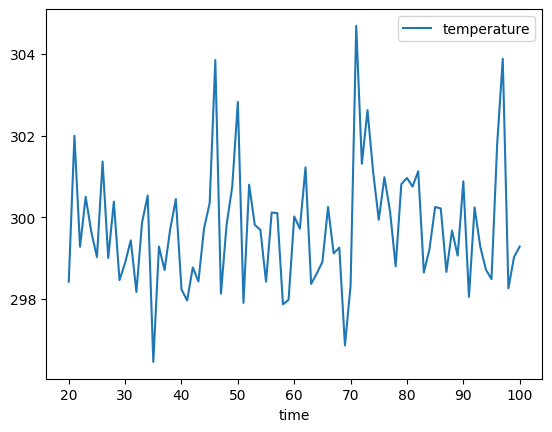

In [71]:
df = pd.read_csv('temperature.xvg', sep='\\s+', header=None, names=['time','temperature'])
df.plot('time')

Or for visualization with Xmgrace, remove the comment characters (#) in the following cells:

In [72]:
#!echo "Temperature" | gmx energy -f nvt.edr -o temperature.xvg -b 20

In [73]:
#!xmgrace temperature.xvg

From the plot, it is clear that the temperature of the system quickly reaches the target value (300 K), and remains stable over the remainder of the equilibration. For this system, an equilibration period (on the order of 50 ps) may be adequate.

# Equilibration run - pressure

In the previous step, NVT equilibration stabilized the temperature of the system. Prior to data collection, we must also stabilize the pressure (and thus also the density) of the system. Equilibration of pressure is conducted under an NPT ensemble, wherein the Number of particles, Pressure, and Temperature are held constant. The ensemble is also called the "isothermal-isobaric" ensemble, and most closely resembles experimental conditions.

The .mdp file used for a 100-ps NPT equilibration can be found in the input file folder. It is not drastically different from the parameter file used for NVT equilibration, but note the addition of the pressure coupling section. We will use the [stochastic cell rescaling](https://manual.gromacs.org/current/reference-manual/algorithms/molecular-dynamics.html#stochastic-cell-rescaling) as barostat. The stochastic cell rescaling algorithm is a variant of the Berendsen algorithm that allows correct fluctuations to be sampled.

Let's have a look at the mdp file:

In [74]:
!cat input/npt-charmm.mdp

title                   = CHARMM NPT equilibration 
define                  = -DPOSRES  ; position restrain the protein 

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

continuation            = yes      

; Pressure coupling is on
pcoupl                  = C-rescale             ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 5.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling        = com

; Keep sy

We made a few more changes compared to the NVT run:

- `continuation = yes`: We are continuing the simulation from the NVT equilibration phase
- `gen_vel = no`: Velocities are read from the trajectory (see below) 

We will call `grompp` and `mdrun` just as we did for the NVT equilibration. Note that we are now using the `-t` flag to include the checkpoint file outputted from the NVT equilibration. This file contains all the necessary state variables to continue our simulation from a previous one. To conserve the velocities produced during the NVT run, we must include the final coordinate file outputted from the the NVT simulation, using the `-c` option.

In [75]:
!gmx grompp -f input/npt-charmm.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx grompp -f input/npt-charmm.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -503349557

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Taking veloci

Now, we'll start the NPT MD simulation - this one will take a few minutes.

In [76]:
!gmx mdrun -ntmpi 1 -ntomp 8 -v -deffnm npt

                      :-) GROMACS - gmx mdrun, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx mdrun -ntmpi 1 -ntomp 8 -v -deffnm npt

Reading file npt.tpr, VERSION 2025.0 (single precision)
Changing nstlist from 10 to 100, rlist from 1.2 to 1.349

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 8 OpenMP threads 


NOTE: OS CPU limit is lower than logical cpu count, thread pinning disabled.
starting mdrun 'COAGULATION FACTOR XA'
50000 steps,    100.0 ps.
step 11300: timed with pme grid 56 56 56, coulomb cutoff 1.200: 102.2 M-cycles
step 11500: timed with pme grid 48 48 48, coulomb cutoff 1.378: 135.0 M-cycles
step 11700: timed with pme g

*Note: If the simulation takes too long to run for this tutorial, you may use the pre-computed data by copying it to the current directory (just remove the comment characters, #, below). But remember that you can always check/analyse the output files while the simulation is still running.*

In [56]:
##ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/npt_charmm.edr npt.edr
#!cp reference/npt_charmm.gro npt.gro
#!cp reference/npt_charmm.cpt npt.cpt

Let's analyze the pressure as a function of time, again using `gmx energy`:

In [77]:
!echo "Pressure" | gmx energy -f npt.edr -o pressure.xvg -xvg none

                      :-) GROMACS - gmx energy, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx energy -f npt.edr -o pressure.xvg -xvg none

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X           20  Box-Y         
 21  Box-Z           22  Volume          23  Density         24  pV    

<Axes: xlabel='time'>

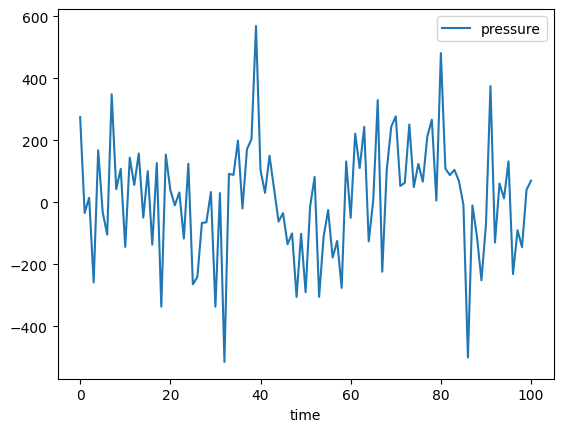

In [78]:
df = pd.read_csv('pressure.xvg', sep='\\s+', header=None, names=['time','pressure'])
df.plot('time')

Alternatively, for visualization using Xmgrace, remove the comment characters (#) in the following cells:

In [79]:
#!echo "Pressure" | gmx energy -f npt.edr -o pressure.xvg

In [80]:
#!xmgrace pressure.xvg

The pressure value fluctuates widely over the course of the 100-ps equilibration phase, but this behavior is not unexpected. The reference pressure was set to 1 bar, so is this outcome acceptable? Pressure is a quantity that fluctuates widely over the course of an MD simulation, as is clear from the large root-mean-square fluctuation (in the order of 100 bar), so statistically speaking, one cannot distinguish a difference between the obtained average and the target/reference value (1 bar). The important point is that the average pressure remains on the same order of magnutude as the target pressure.

Let's take a look at density using `gmx energy`:

In [81]:
!echo "Density" | gmx energy -f npt.edr -o density.xvg -xvg none

                      :-) GROMACS - gmx energy, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx energy -f npt.edr -o density.xvg -xvg none

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X           20  Box-Y         
 21  Box-Z           22  Volume          23  Density         24  pV     

<Axes: xlabel='time'>

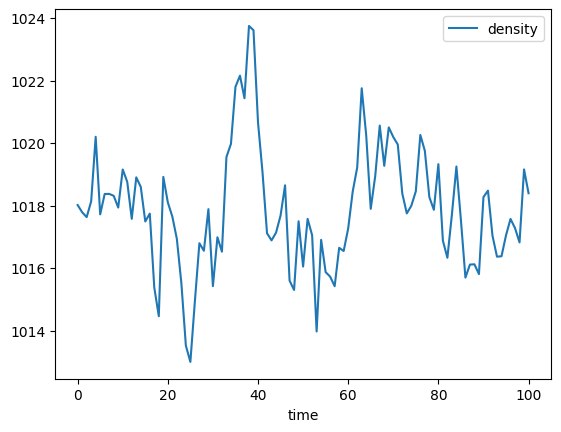

In [82]:
df = pd.read_csv('density.xvg', sep='\\s+', header=None, names=['time','density'])
df.plot('time')

Alternatively, for visualization using Xmgrace, remove the comment characters (#) in the following cells:

In [83]:
#!echo "Density" | gmx energy -f npt.edr -o density.xvg

In [84]:
#!xmgrace density.xvg

The average value is close to the experimental value of 1000 kg m-3 and the expected density of the TIP3P model of 1001 kg m-3. The parameters for the TIP3P water model closely replicate experimental values for water. However, since we also have a protein in the box we can expect the density to be a little bit higher than that of pure water, which is also what we see from our plot. The density values are very stable over time, indicating that the system is now well-equilibrated with respect to pressure and density.

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> Pressure-related terms are slow to converge, so a longer NPT equilibration might be needed for other systems.
</div>

# The "production" run

Upon completion of the two equilibration phases, the system is now well-equilibrated at the desired temperature and pressure. We are now ready to release the position restraints of the protein atoms and launch our production MD simulation for data collection. The process is just like we have seen before, but we will now continue the simulation from the checkpoint file ouputted from the NPT run. We will now run a 1-ns MD simulation. In the mdp-file, we have added a section that controls the output frequency for data in the log file (.log), energy file (.edr), trajcotry file (.trr), and compressed trajectory file (.xtc). Writing data too frequently will lead to significantly longer run times and larger output files, while too infrequent writes will result in loss of detail in the final trajectories. It is thus a good idea to think about how much time resolution your planned analysis will require before launching the simulation.

Let's take a look at the mdp file for the production run:

In [85]:
!cat input/md-charmm.mdp

title                   = CHARMM NPT  

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 500000     ;  1000 ps = 1 ns

; periodic boundary condition
pbc                     = xyz       ;

continuation            = yes      

; Output control - output frequency in steps
; Output frequency for  output trajctory file ,trr
nstxout                  = 0       ; for writing coords (x) 
nstvout                  = 0       ; for writing velocities (v) 
nstfout                  = 0       ; for writing forces (f) 
; Output frequency for energies to log file and energy file
nstlog                   = 1000    ; for writing energies to log file
nstenergy                = 500     ; for writing energies to edr file 
; Output frequency and precision for .xtc file
nstxout-compressed       = 2500    ; for writing coords (x) 

; Pressure coupling is on
pcoupl     

Here, we use velocity-rescaling temperature coupling as thermostat and stochastic cell rescaling as barostat. A full explanation of the available thermostats and barostats in GROMACS can be found in the manual (see [here](http://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#temperature-coupling) for thermostats and [here](http://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#pressure-coupling) for barostats). 

Note that for thermostats and barostats, we need to compute the temperature or pressure of the system. This requires global communication and is currently not done on the GPU. To reduce the computational cost, [nsttcouple](https://manual.gromacs.org/current/user-guide/mdp-options.html#mdp-nsttcouple) and [nstpcouple](https://manual.gromacs.org/current/user-guide/mdp-options.html#mdp-nstpcouple) (frequency for coupling temperature and pressure) are set to 100 by default in GROMACS 2023 (see the webinar [What's new in GROMACS2023](https://www.gromacs.org/tutorial_webinar.html). The recommendation is to use tau_t = 1 ps for V-rescale and tau_p = 5 ps for C-rescale. 

`gmx grompp` will print an estimate for generated data and PME load. The PME load number tells us how many processors should be dedicated to the PME calculation, and how many for the PP (everything except for PME) calculations. Refer to the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdrun-performance.html#parallelization-schemes) for details.

In [86]:
!gmx grompp -f input/md-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx grompp -f input/md-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -411631790

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Taking velocities from 'np

In [87]:
!gmx mdrun -ntmpi 1 -ntomp 8 -v -deffnm md 

                      :-) GROMACS - gmx mdrun, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx mdrun -ntmpi 1 -ntomp 8 -v -deffnm md

Reading file md.tpr, VERSION 2025.0 (single precision)
Changing nstlist from 10 to 100, rlist from 1.2 to 1.349

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 8 OpenMP threads 


NOTE: OS CPU limit is lower than logical cpu count, thread pinning disabled.
starting mdrun 'COAGULATION FACTOR XA'
500000 steps,   1000.0 ps.
step 11300: timed with pme grid 56 56 56, coulomb cutoff 1.200: 102.1 M-cycles
step 11500: timed with pme grid 48 48 48, coulomb cutoff 1.378: 133.2 M-cycles
step 11700: timed with pme gr

As before, this run will take some time - probably more than planned for going through this tutorial. The flag -ntpmi provides the number of thread-MPI ranks to start and -ntomp the number of OpenMP threads per MPI rank to start. The optimal values for those flag depends on the resource you use to run the simulation. 
If you want to proceed without waiting, copy the pre-computed data to your working directory by removing the comment characters (#):

In [ ]:
##ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/md_charmm.log md.log
#!cp reference/md_charmm.edr md.edr
#!cp reference/md_charmm.gro md.gro
#!cp reference/md_charmm.xtc md.xtc

# Analysis

Now that we have a simulation of our protein, we can start analyzing it! What kind of data is important? This is a relevant question to ask before launching the simulation, so you should have some ideas about the types of data you will want to collect from your simulation beforehand. In this tutorial, we will introduce a few basic GROMACS tools for analyzing simulations, but there are of course many more out there.

[`gmx trjconv`](https://manual.gromacs.org/current/onlinehelp/gmx-trjconv.html) is a useful trajectory post-processing tool that can strip out coordinates, correct for periodicity, or manually alter the trajectory in various ways (setting time units, altering frame frequency, etc). Here you can find a suggested [workflow](https://manual.gromacs.org/2021/user-guide/terminology.html?highlight=periodic%20boundary) for processing trajectories with `gmx trjconv`.

There are many options to use with `gmx trjconv`, let's list them by entering `-h`:

In [88]:
!gmx trjconv -h

                     :-) GROMACS - gmx trjconv, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx trjconv -h

SYNOPSIS

gmx trjconv [-f [<.xtc/.trr/...>]] [-s [<.tpr/.gro/...>]] [-n [<.ndx>]]
            [-fr [<.ndx>]] [-sub [<.ndx>]] [-drop [<.xvg>]]
            [-o [<.xtc/.trr/...>]] [-b <time>] [-e <time>] [-tu <enum>]
            [-[no]w] [-xvg <enum>] [-skip <int>] [-dt <time>] [-[no]round]
            [-dump <time>] [-t0 <time>] [-timestep <time>] [-pbc <enum>]
            [-ur <enum>] [-[no]center] [-boxcenter <enum>] [-box <vector>]
            [-trans <vector>] [-shift <vector>] [-fit <enum>] [-ndec <int>]
            [-[no]vel] [-[no]force] [-trunc <time>] [-exec <string>]
            [-split <time>] [-[no]sep] [-nzero <int>] [-dropunder <real>]
            [-dropover <real>] [-[no]conect]

DESCRIPTION

gmx trjconv can convert trajectory files in many ways:

* from one format t

In this exercise, we will use the `-center` and `-pbc` options to account for any periodicity in the system. During the simulation, the protein will diffuse across the unit cell, and may appear "broken" or "jump" from one side of the simulation box to the other. To center the protein in the box, we run the following:

In [112]:
!printf "1\n1\n" | gmx trjconv -s md.tpr -f md.xtc -o md_center.xtc -center -pbc mol
!printf "1\n1\n" | gmx trjconv -s md.tpr -f md_center.xtc -o md_center_nj.xtc -center -pbc nojump

                     :-) GROMACS - gmx trjconv, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx trjconv -s md.tpr -f md.xtc -o md_center.xtc -center -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file md.tpr, VERSION 2025.0 (single precision)
Reading file md.tpr, VERSION 2025.0 (single precision)
Select group for centering
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Gro

Select 1 ("Protein") as the group to be centered and 1 ("Protein") for output. We will conduct all our analyses on this "corrected" trajectory. Now, let's look at the post-processed trajectory using NGLview: 

In [114]:
#traj = md.load("md_center.xtc", top="1fjs_newbox.gro")
traj = md.load("md_center_nj.xtc", top="1fjs_newbox.gro")
view = ng.show_mdtraj(traj)
view

NGLWidget(max_frame=200)

Alternatively, remove the comment character (#) to use VMD to visualize the simulation:

In [ ]:
#!vmd 1fjs_newbox.gro md_center.xtc

## Check the minimum image convention

Next, we will calculate the distance between the protein and its periodic image. The protein should never interact with its periodic image (minimum image convention), or else the forces calculated will be spurious. We will now use the tool [`gmx mindist`](https://manual.gromacs.org/current/onlinehelp/gmx-mindist.html) with the option `-pi` to validate that the distance is large enough: 

In [71]:
!printf "1\n" | gmx mindist -s md.tpr -f md_center.xtc -pi -od mindist.xvg 
#!xmgrace mindist.xvg

                     :-) GROMACS - gmx mindist, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx mindist -s md.tpr -f md_center.xtc -pi -od mindist.xvg

Choose a group for distance calculation
Reading file md.tpr, VERSION 2025.0 (single precision)
Reading file md.tpr, VERSION 2025.0 (single precision)
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    10 (    Prot-Masses) has  4417 elements
Group    11 (    non-Protein) has 

The distance between the protein and its periodic image should not be smaller than the cut-off used to describe non-bonded interactions.

## Evaluate structural stability with RMSD

Now, let's look at structural stability. GROMACS has a built-in tool for RMSD calculations called [`gmx rms`](https://manual.gromacs.org/current/onlinehelp/gmx-rms.html). To calculate the RMSD relative to the crystal structure, we can run the following command:

In [72]:
!printf "4\n1\n" | gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns -xvg none

                       :-) GROMACS - gmx rms, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns -xvg none

Reading file em.tpr, VERSION 2025.0 (single precision)
Reading file em.tpr, VERSION 2025.0 (single precision)
Select group for least squares fit
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    10 (    Prot-Masses) has  4417 elements
Group    11 (    non-Protein) h

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> It is important that the reference structure has the same number of atoms as the trajectory file, or otherwise the calculation will fail. This can be easy to miss when using experimental structures rather than simulation frames as reference.
</div>

Here, we chose 4 ("Backbone") as the group for both the least-squares fit and RMSD calculation. The `-tu` flag allows us to set the time unit of the output and we chose ns to get nicer numbers as the original trajectory output was written in ps. Setting the time unit is particularly useful when dealing with longer simulations. The output plot will show the RMSD relative to the structure from the original pdb file:


<Axes: xlabel='time'>

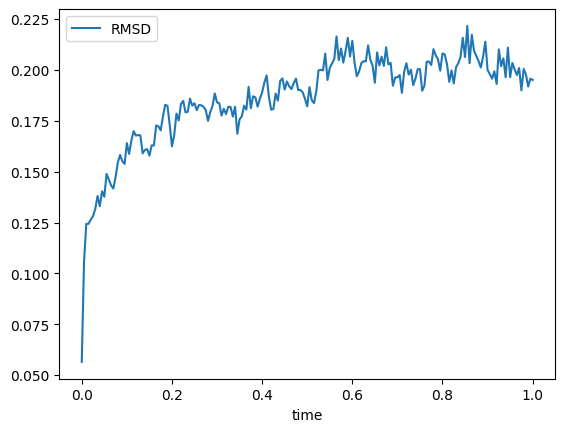

In [73]:
df = pd.read_csv('rmsd_xray.xvg', sep='\\s+', header=None, names=['time','RMSD'])
df.plot('time')

Or for visualization using Xmgrace, remove the comment characters (#) in the following cells:

In [74]:
#!printf "4\n1\n" | gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns

In [75]:
#!xmgrace rmsd_xray.xvg 

The plot shows that the RMSD levels off around 0.15 nm (1.5 Å), indicating that the simulated structure is stable.

## Measure compactness with radius of gyration

The radius of gyration (Rg) of a protein is a measure of its compactness. If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time. Let's analyze the radius of gyration for the protein in our simulation using [`gmx gyrate`](https://manual.gromacs.org/current/onlinehelp/gmx-gyrate.html):

In [76]:
!echo "1" | gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg -xvg none

                      :-) GROMACS - gmx gyrate, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg -xvg none

Reading file md.tpr, VERSION 2025.0 (single precision)
Reading file md.tpr, VERSION 2025.0 (single precision)
Last frame        200 time 1000.000   
Analyzed 201 frames, last time 1000.000

GROMACS reminds you: "By three methods we may learn wisdom: First, by reflection, which is noblest; Second, by imitation, which is easiest; and third by experience, which is the bitterest." (Confucius)



<Axes: xlabel='time'>

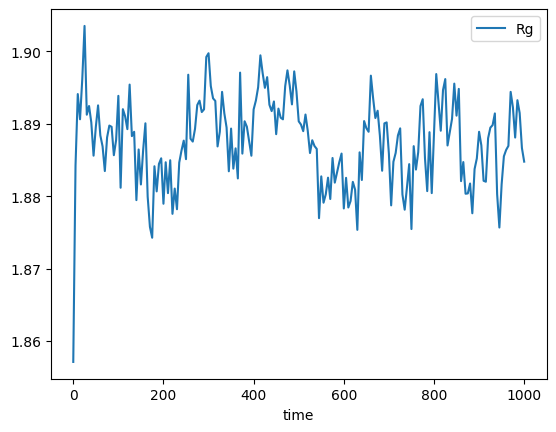

In [77]:
df = pd.read_csv('gyrate.xvg', sep='\\s+', header=None, names=['time','Rg'], usecols=[0, 1])
df.plot('time')

Or for visualization using Xmgrace, remove the comment characters (#) in the following cells:

In [78]:
#!echo "1" | gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg 

In [79]:
#!xmgrace gyrate.xvg

The reasonably invariant Rg values indicates that the protein remains very stable in its compact (folded) form over the course of the 1 ns simulation. This result is not unexpected, but illustrates an advanced capacity of GROMACS analysis that comes built-in.

## Index files for more specific atom selection

So far, we have focused our analysis on the whole protein, but if we wish to select specific sets of atoms for analysis we need to create index groups. Common selections such as the system, protein, solvent, ions etc. are provided as default options through promps in most GROMACS tools, but for more complex selections we need to use `gmx make_ndx`or the newer `gmx_select` to create an index (.ndx) file. 

First, we will use `gmx make_ndx` to split the protein into its two chains. This tool has its own atom selection language which can be listed through typing `h` into the promt. The command `q`  will close the tool:

In [ ]:
!printf "h\nq\n" | gmx make_ndx -f nvt.tpr -o

To split the protein into chains we will use the selection `splitch 1`, where `1` represents the protein:

In [80]:
!printf "splitch 1\nq\n" | gmx make_ndx -f nvt.tpr -o chains_make_ndx.ndx

                     :-) GROMACS - gmx make_ndx, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx make_ndx -f nvt.tpr -o chains_make_ndx.ndx


Reading structure file
Reading file nvt.tpr, VERSION 2025.0 (single precision)
Reading file nvt.tpr, VERSION 2025.0 (single precision)
Going to read 0 old index file(s)
Analysing residue names:
There are:   286    Protein residues
There are: 11703      Water residues
There are:    74        Ion residues
Analysing Protein...

  0 System              : 39600 atoms
  1 Protein             :  4417 atoms
  2 Protein-H           :  2238 atoms
  3 C-alpha             :   286 atoms
  4 Backbone            :   858 atoms
  5 MainChain           :  1142 atoms
  6 MainChain+Cb        :  1401 atoms
  7 MainChain+H         :  1423 atoms
  8 SideChain           :  2994 atoms
  9 SideChain-H         :  1096 atoms
 10 Prot-Masses         : 

An alternative way to create index groups is to use the newer tool `gmx select`, which allows for dynamic selections in addition to almost all the functionality of `gmx make_ndx`. The selection syntax is a bit different compared to that of `gmx make_ndx`, but a detailed guide is available in the [GROMACS manual](https://manual.gromacs.org/current/onlinehelp/selections.html).

Now, we will create the index file defining the two chains using `gmx select`.

Note that a "chain" selection is available in `gmx select`, but can only be applied if chain identifiers exist in the topology file. In most gro or tpr files the chain information is lost, so we select the separate protein molecules instead:

In [82]:
!printf "group "Protein" and mol 1\ngroup "Protein" and mol 2" | gmx select -s nvt.tpr -on chains_select.ndx

                      :-) GROMACS - gmx select, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx select -s nvt.tpr -on chains_select.ndx

Reading file nvt.tpr, VERSION 2025.0 (single precision)
Reading file nvt.tpr, VERSION 2025.0 (single precision)
Analyzed topology coordinates

GROMACS reminds you: "Carbohydrates is all they groove" (Frank Zappa)



Now, we can calculate the number of hydrogen bonds between the two protein chains using the tool `gmx hbond` (see the [manual](https://manual.gromacs.org/current/onlinehelp/gmx-hbond.html)). The `-num` option provides the number of hydrogen bonds as a function of time. 
We can use the index file obtained from `gmx make_ndx` to specify the chains 
Then we use the index file obtained from `gmx select` to specify the chains:

In [81]:
!printf "17\n18\n"| gmx hbond -f md.xtc -s md.tpr  -n chains_make_ndx.ndx -num hbnum_ndx.xvg -xvg none

                      :-) GROMACS - gmx hbond, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx hbond -f md.xtc -s md.tpr -n chains_make_ndx.ndx -num hbnum_ndx.xvg -xvg none

Reading file md.tpr, VERSION 2025.0 (single precision)
Reading file md.tpr, VERSION 2025.0 (single precision)

Checking for overlap in atoms between Protein_chain1 (941 atoms) and Protein_chain2 (37 atoms)
Selection 'Protein_chain1' has 175 acceptors and 87 donors.
Selection 'Protein_chain2' has 10 acceptors and 3 donors.
Last frame        200 time 1000.000   
Analyzed 201 frames, last time 1000.000

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
S. Gorelov, A. Titov, O. Tolicheva, A. Konevega, A. Shvetsov
Determination of Hydrogen Bonds in GROMACS: A New Implementation to Overcome
Memory Limitation
Journal of Chemical Information and Modeling (2024)
DOI: 10.1021/acs.jcim.3c02087
----

Or we use the index file obtained from `gmx select` to specify the chains:

In [83]:
!printf "0\n1\n"| gmx hbond -f md.xtc -s md.tpr -n chains_select.ndx -num hbnum.xvg -xvg none

                      :-) GROMACS - gmx hbond, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx hbond -f md.xtc -s md.tpr -n chains_select.ndx -num hbnum.xvg -xvg none

Reading file md.tpr, VERSION 2025.0 (single precision)
Reading file md.tpr, VERSION 2025.0 (single precision)

Checking for overlap in atoms between group_Protein_and_mol_1_ (3673 atoms) and group_Protein_and_mol_2_ (744 atoms)
Selection 'group_Protein_and_mol_1_' has 673 acceptors and 351 donors.
Selection 'group_Protein_and_mol_2_' has 147 acceptors and 70 donors.

Back Off! I just backed up hbond.ndx to ./#hbond.ndx.1#
Last frame        200 time 1000.000   
Analyzed 201 frames, last time 1000.000

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
S. Gorelov, A. Titov, O. Tolicheva, A. Konevega, A. Shvetsov
Determination of Hydrogen Bonds in GROMACS: A New Implementation to Overcome
Memory L

Now we plot both graph

<Axes: xlabel='time'>

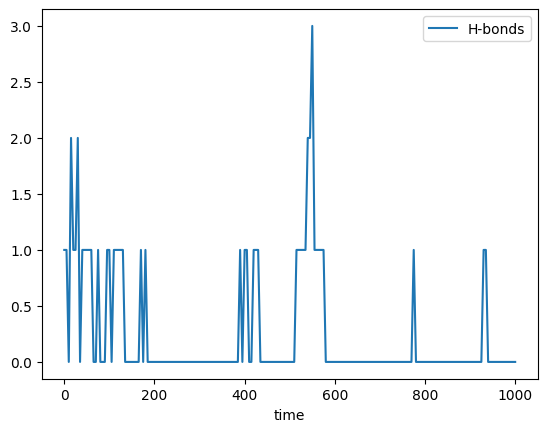

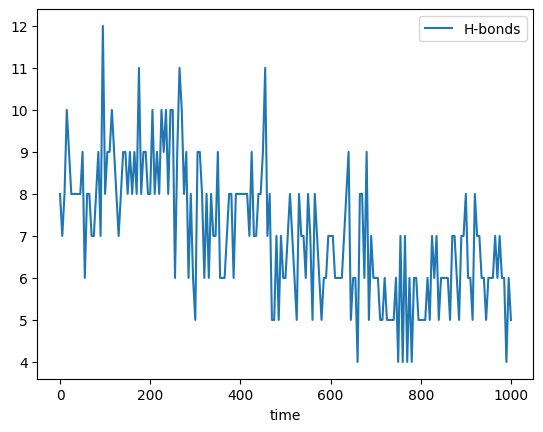

In [84]:
df = pd.read_csv('hbnum_ndx.xvg', sep='\\s+', header=None, names=['time','H-bonds'], usecols=[0, 1])
df.plot('time')
df = pd.read_csv('hbnum.xvg', sep='\\s+', header=None, names=['time','H-bonds'], usecols=[0, 1])
df.plot('time')


Or for visualization using Xmgrace, remove the comment characters (#) in the following cells:

In [ ]:
#!printf "17\n18\n"| gmx hbond -f md.xtc -s md.tpr -n chains_make_ndx.ndx -num hnum_xvg.xvg

In [ ]:
#!xmgrace hbnum_xvg.xvg

# Report methods

Now that we have run the simulation, it might be useful report or recall the settings used to produce it, e.g. for publication. The tool `gmx report-methods` (see the [manual](https://manual.gromacs.org/current/onlinehelp/gmx-report-methods.html)) can be useful for this purpose. `gmx report-methods` prints out basic system information on a performed run. It can also provide an unformatted text (with the option `-o`) or a LaTeX-formatted output file with through the `-m` option. 

Let's try it:

In [85]:
!gmx report-methods -s md.tpr

                  :-) GROMACS - gmx report-methods, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/md-intro-tutorial-main/data
Command line:
  gmx report-methods -s md.tpr

Reading file md.tpr, VERSION 2025.0 (single precision)
section: Methods
subsection: Simulation system
A system of 11779 molecules (39600 atoms) was simulated.

subsection: Simulation settings
A total of 1 ns were simulated with a time step of 2 fs.
Neighbor searching was performed every 10 steps.
The PME algorithm was used for electrostatic interactions.
with a cut-off of 1.2 nm.
A reciprocal grid of 56 x 56 x 56 cells was used with 4th order B-spline interpolation.
A single cut-off of 1.2 nm was used for Van der Waals interactions.
Temperature coupling was done with the V-rescale algorithm.
Pressure coupling was done with the C-rescale algorithm.

GROMACS reminds you: "Your Shopping Techniques are Amazing" (Gogol Bordello)



# Improve performance with longer timesteps

In this tutorial, we have used a time step of 2 fs which is necessary to properly resolve the fastest motions in the simulation, primarily originating from hydrogen atoms. The need for a short timestep constitutes a major challenge in MD simulations since the timescales of interest often are orders of magnitude longer, leading to a high computational cost of typical simulations. There are a few different algorithms in GROMACS that can allow for a longer timestep and thus "faster simulations", but beware that they always come with some trade-offs to the dynamics. 

In this section, we will discuss and provide mdp files for two methods:
* Mass repartitioning
* Multiple time-stepping

If you want to test these methods yourself, just replace the mdp file in the `gmx grompp` command for the production MD run with the updates presented in this section.

First, let's discuss **mass repartitioning**. The general idea is to increase the mass of lighter atoms to slow down the fastest fluctuations in the system. This way, we can use a longer timestep to resolve all motions. For typical atomistic systems only the masses of hydrogen atoms are scaled.

Let's take a look at the mdp file for running with mass repartitioning:

In [ ]:
!cat input/md-mass-charmm.mdp

Compared to the mdp file used previously in this tutorial, we have added the `mass-repartition-factor = 3` and doubled the timestep to 4 fs (`dt = 0.004`). This means we scale the lightest masses by a factor 3 by moving this extra mass from the heavier atom it is bound to. Exactly which numbers to use depends on the force field, but the settings used here usually works well for most systems with constrained hydrogen bonds (note the line `constraints = h-bonds`).

In [ ]:
!gmx grompp -f input/md-mass-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md-mass.tpr

In [ ]:
!gmx mdrun -v -deffnm md-mass -ntmpi 1 -ntomp 8

Next, we will take a look at the **multiple time-stepping** algorithm. The idea is to compute some types of forces less frequently than than every timestep, thereby reducing the computational cost. Exactly which combinations of forces and timesteps to use is still an area under investigation and also depends on the rest of the force field. Therefore, it is always a good idea to be conservative and to assess stability and energy drifts when using this method.

Let's take a look at the mdp file when using multiple time-stepping:

In [ ]:
!cat input/md-mts-charmm.mdp

We can find the mdp options related to multiple time-stepping at the bottom of the file, all with the prefix "mts". First, turn on multiple time-stepping with `mts = yes`. In theory, it is possible to use multiple time-stepping on more than two levels, but only two level are currently implemented in GROMACS, so we use only `mts-levels = 2`. Then, we specify which types of forces to calculate less frequently (on the second mts-level) through the `mts-level2-forces`. `mts-level2-forces` supports the following entries longrange-nonbonded, nonbonded, pair, dihedral, angle, pull and awh. Note longrange-nonbonded can not be omitted

Here, we select long-range non-bonded interactions. The `mts-level2-factor` specifies the interval for computing the forces in the second level. We set it to 2, which means we calculate these forces half as often.  Note the mdp parameter `nstlist` should be a multiple of `mts-level2-factor`.

In [ ]:
!gmx grompp -f input/md-mts-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md-mts-charmm.tpr
!gmx mdrun -v -deffnm md-mts-charmm -ntmpi 1 -ntomp 8

If we run simulations with either hydrogen mass repartitioning or multiple time-stepping we get the following performance improvements on 8 CPU (ADM EPYC-Milan):

| Simulation             | Performance (ns/day) |
| :--------------------- | ----------: |
| Regular MD                       |    26.9     | 
| Mass repartitioning              |    52.3     | 
| Multiple time-stepping           |             | 
|   `longrange-nonbonded`          |    28.3     |
|   `nonbonded longrange-nonbonded`|    50.8     |

For multiple time-stepping we report results only for two combinations `longrange-nonbonded` and `nonbonded longrange-nonbonded`. To get the best combination for a system, different combinations of entries for multiple time-stepping can test. The setting is also force field dependent.

In conclusion, we can get performance improvements by using mass repartitioning and multiple time-stepping, but keep in mind they also slightly alter the dynamics of the system. 

## Do you have any questions? Have a look at the user discussions on the [GROMACS forum](htttp://forums.gromacs.org)

In [109]:

!printf " 0\n 0\n" | gmx trjconv -f  1fjs_newbox.gro -center -o newbox1.gro -s 1fjs_newbox.gro

                     :-) GROMACS - gmx trjconv, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /workspace/GMX_on_Runpod/data
Command line:
  gmx trjconv -f 1fjs_newbox.gro -center -o newbox1.gro -s 1fjs_newbox.gro

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write gro: Coordinate file in Gromos-87 format
Select group for centering
Group     0 (         System) has  4417 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Select a group: Selected 0: 'System'
Select group for output
Group    

In [118]:
view = ng.show_structure_file("1fjs_newbox.gro")
#view.add_structure_file("1fjs_newbox.gro")
view.add_representation(repr_type='spacefill', selection='NA')
view.add_representation(repr_type='spacefill', selection='CL')
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'
view

NGLWidget()